Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

Data Load

- `SPX` : S&P 500 Index
- `UX_C` : VIX 1st Futures (Continuous) (수익률 계산용)
- `UX_R` : VIX 1st Futures (Raw) (거래비용 계산용)
- `VIX` : VIX Index
- `VIX3M` : VIX 3M Index

In [2]:
df = pd.read_pickle('vt_df.pkl')

In [3]:
df

,SPX,UX_C,UX_R,VIX,VIX3M
2004-03-29,1122.47,1.365776e+09,19.8000,16.50,17.93
2004-03-30,1127.00,1.353360e+09,19.6200,16.28,17.99
2004-03-31,1126.21,1.362327e+09,19.7500,16.74,17.98
2004-04-01,1132.17,1.353360e+09,19.6200,16.65,18.02
2004-04-02,1141.81,1.303006e+09,18.8900,15.64,17.23
...,...,...,...,...,...
2025-08-06,6345.06,1.760480e+01,17.6048,16.77,19.47
2025-08-07,6340.00,1.779780e+01,17.7978,16.57,19.35
2025-08-08,6389.45,1.686800e+01,16.8680,15.15,18.70
2025-08-11,6373.45,1.690140e+01,16.9014,16.25,19.25


Data Preprocessing

In [4]:
# 1-tick Slippage Cost as Percentage of Close Price
df['Cost'] = 0.05 / df['UX_R']

# SPX 2-Day Realized Volatility (%)
df['RV'] = df['SPX'].pct_change().rolling(2).std() * np.sqrt(252) * 100

# Volatility Risk Premium
df['VRP'] = df['VIX'] - df['RV']

# Volatility Term Structure
df['VTS'] = df['VIX3M'] / df['VIX']

Backtesting

In [5]:
vt_notional = 1e9
df['weight'] = np.where((df['VRP'] < 0) & (df['VTS'] < 1), df['VIX'] / 100 * 1, 0)
df['notional'] = df['weight'] * vt_notional
df['pnl'] = df['notional'].shift() * df['UX_C'].pct_change() - np.abs(df['notional'].diff()) * df['Cost']

Strategy Notional

Text(0.5, 1.0, 'VIX Tail-Risk Hedging Strategy')

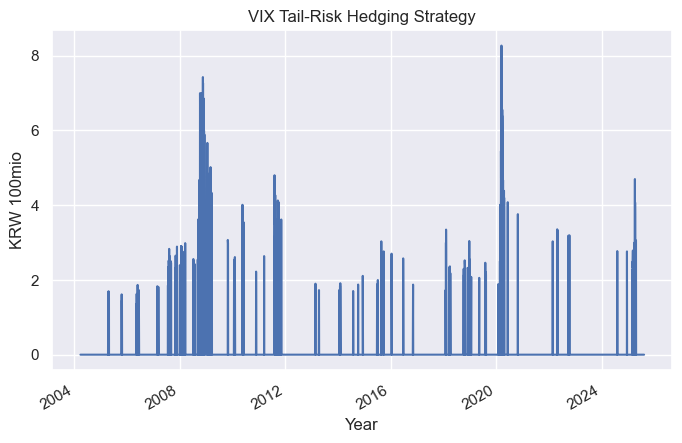

In [6]:
(df['notional']/1e8).plot(figsize=(8, 5))
plt.xlabel('Year')
plt.ylabel('KRW 100mio')
plt.title('VIX Tail-Risk Hedging Strategy')

Text(0.5, 1.0, 'Strategy Performance')

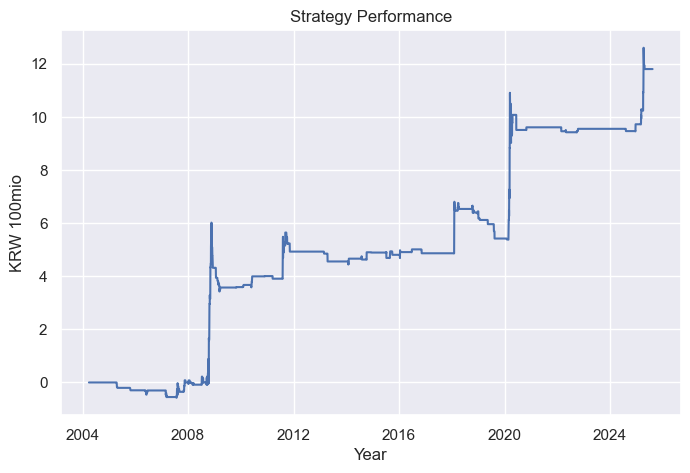

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(df['pnl'].cumsum()/1e8)
plt.xlabel('Year')
plt.ylabel('KRW 100mio')
plt.title('Strategy Performance')

Save Result

- `pnl` : VIX Tail-Risk Hedge P&L
- `notional` : VIX Tail-Risk Hedge Notional

In [8]:
vt_res_df = df[['pnl', 'notional']]
vt_res_df.to_pickle('vt_res_df.pkl')